# Projeto de Machine Learning: Diagnóstico de Câncer de Mama

## Introdução
Este projeto tem como objetivo desenvolver modelos preditivos capazes de classificar diagnósticos de câncer de mama como **malignos** ou **benignos**, utilizando o clássico conjunto de dados **Breast Cancer Wisconsin (Diagnostic)**, disponível no Kaggle.

O foco principal é minimizar a quantidade de **falsos negativos** — ou seja, evitar que casos malignos sejam classificados incorretamente como benignos. Esse cuidado é especialmente importante em contextos clínicos, onde a falha na detecção de um tumor pode ter consequências graves.

### Etapas do projeto:
- Análise exploratória e tratamento dos dados;
- Seleção de variáveis utilizando diferentes técnicas:
  - Correlação,
  - PCA (Principal Component Analysis),
  - RFE (Recursive Feature Elimination),
  - SelectKBest;
- Treinamento de diversos algoritmos de classificação:
  - Regressão Logística,
  - Random Forest,
  - XGBoost,
  - Support Vector Classifier (SVC),
  - K-Nearest Neighbors (KNN);
- Avaliação e comparação dos modelos com base nas métricas:
  - **Recall**,
  - **F1-Score**,
  - **Precision**,
  - **Accuracy**,
  - **AUC-ROC**;

Ao final, os resultados obtidos são comparados e discutidos, com destaque para o modelo que melhor atende ao objetivo principal: **reduzir os falsos negativos sem comprometer o desempenho geral da classificação.**

## Importando as biliotecas

In [1]:
import os
import sys
import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    RocCurveDisplay, accuracy_score, auc, classification_report,
    confusion_matrix, f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve
)
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC

sys.path.append(os.path.abspath(".."))
from src.feature_selection import feature_selection_rfe_xgb
from src.model_evaluation import (
    make_pipeline, evaluate_model, plot_confusion_matrix, train_and_evaluate_model
)
from src.models import (
    plot_multiple_roc_auc, train_knn, train_logistic_regression,
    train_random_forest, train_svc, train_xgboost
)

from src.utils import (
    load_data, plot_correlation_heatmap, plot_swarm_features,
    plot_violin_features, show_basic_info, split_data
)

from sklearn.neighbors import KNeighborsClassifier

import shap

plt.style.use('seaborn-v0_8-darkgrid')

## Carregando e explorando os dados

In [2]:
df = load_data("../data/breast cancer kaggle.csv")

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
show_basic_info(df)

Shape: (569, 33)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  pe

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


# Pré-processamento dos dados

## Codificando dados categóricos

In [5]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

## Checando se algum ID se repete

In [6]:
df['id'].duplicated().sum()

0

## Verificando valores nulos

In [7]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [8]:
y = df['diagnosis']

drop_list = [
    'Unnamed: 32',
    'id',
    'diagnosis'
]

X = df.drop(drop_list, axis = 1 )
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Observando a distribuição das classes no dataset

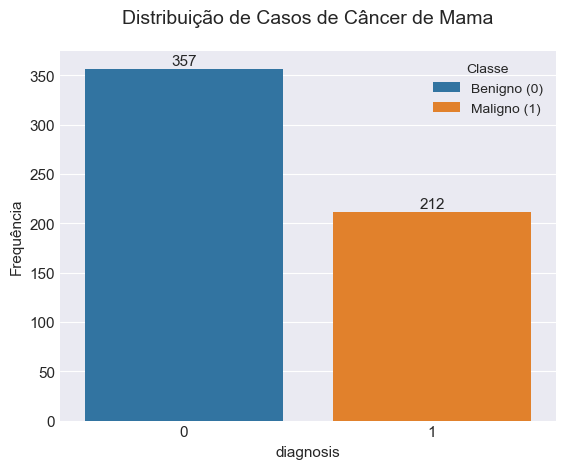

In [9]:
bars = sns.countplot(x=y, hue=y, palette=['#1f77b4', '#ff7f0e'], legend=False)
plt.title("Distribuição de Casos de Câncer de Mama", fontsize=14, pad=20)

for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '{:.0f}'.format(height),
             va='bottom', ha='center', fontsize=11)
    
plt.xlabel(y.name, fontsize=11)
plt.ylabel('Frequência', fontsize=11)
plt.legend(title="Classe", labels=["Benigno (0)", "Maligno (1)"], loc="upper right")
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

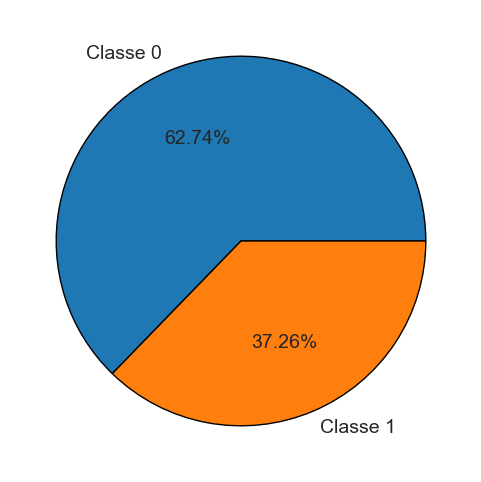

In [10]:
unique, counts = np.unique(y, return_counts=True)

total = len(y)
percentages = counts / total * 100

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=[f'Classe {int(u)}' for u in unique], autopct='%1.2f%%', colors=['#1f77b4', '#ff7f0e'],
        wedgeprops={'edgecolor': 'black', 'linewidth': 1}, textprops={'fontsize': 14})

plt.show()

Observa-se que a distribuição das classes está desbalanceada, com uma predominância de casos benignos em relação aos malignos. Esse desbalanceamento será considerado durante a construção e avaliação dos modelos preditivos.

## Visualização

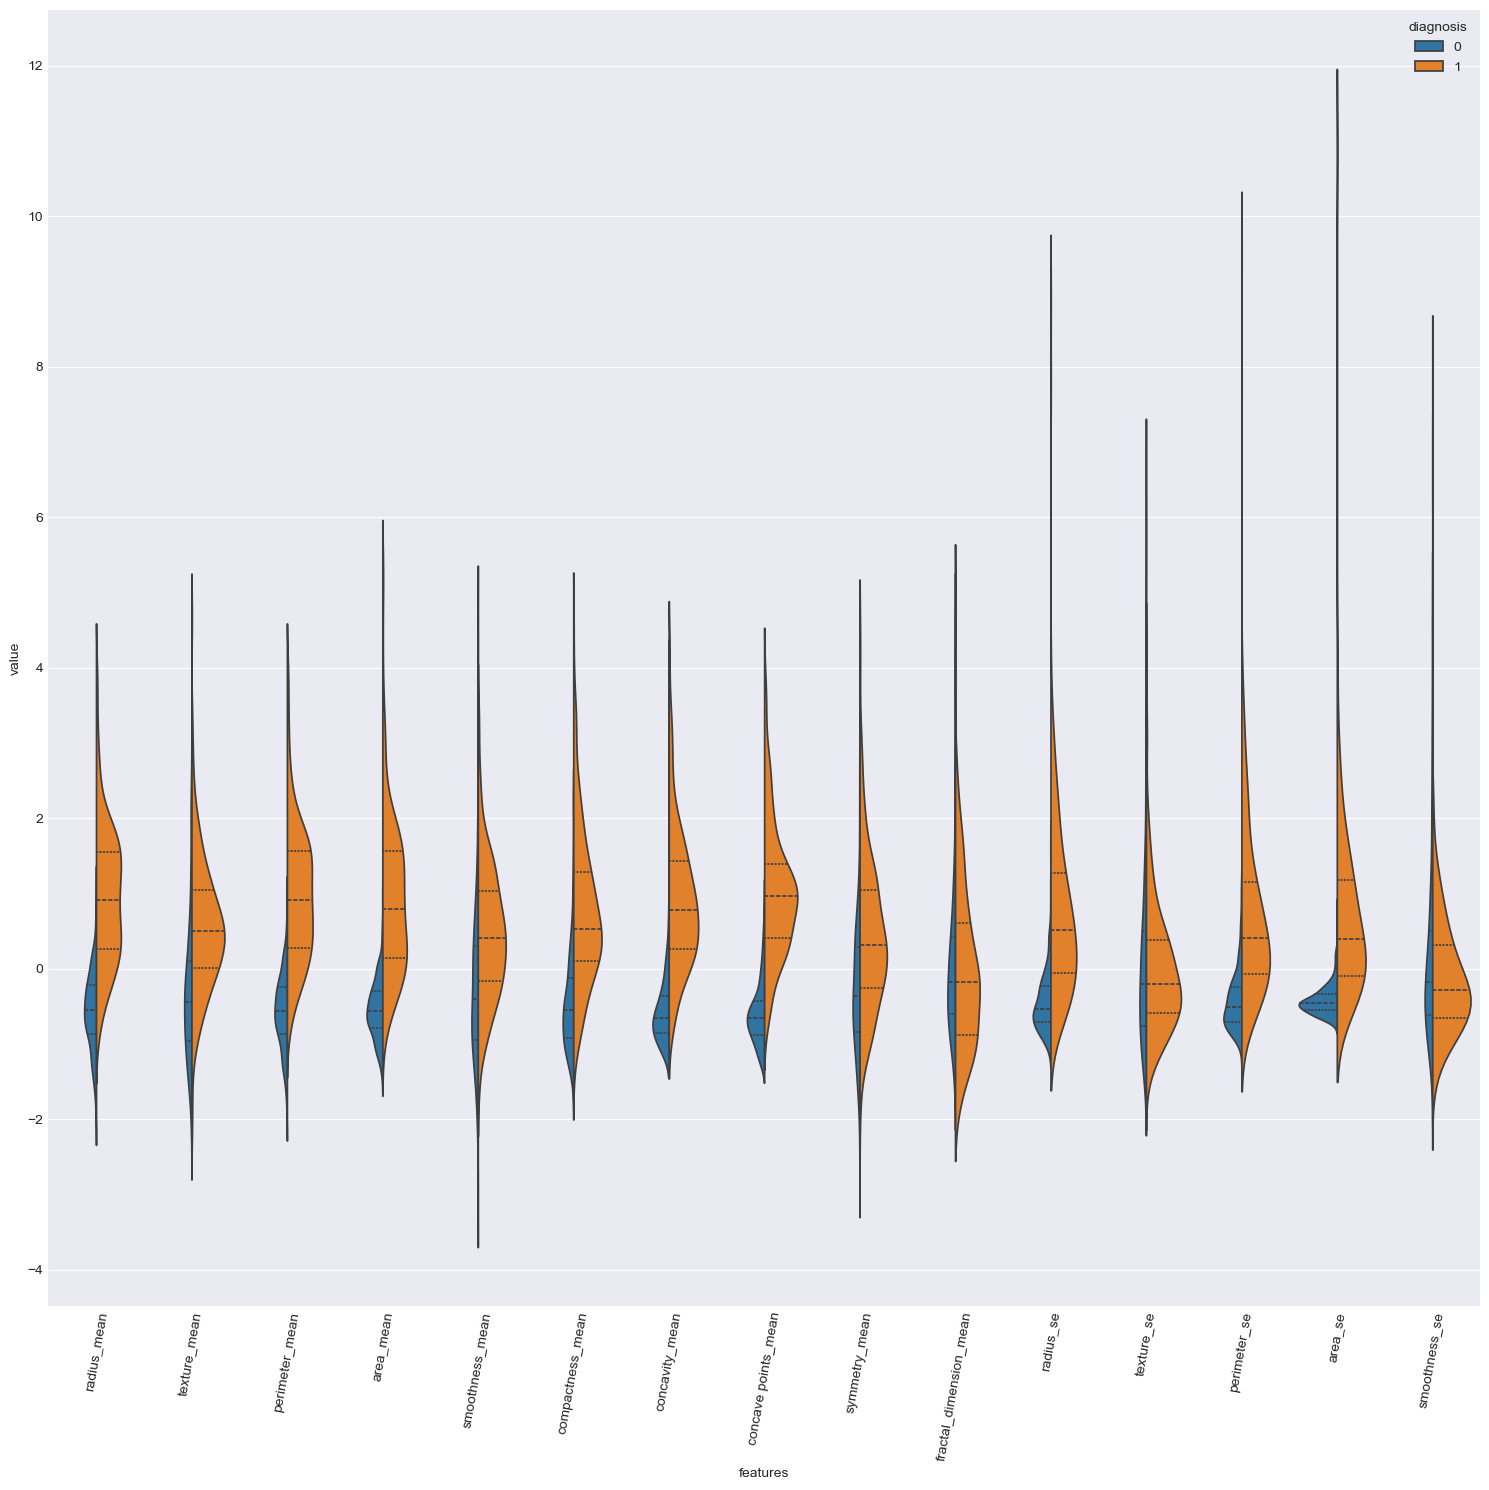

In [11]:
# Primeiras quinze features
plot_violin_features(X, y, start=0, end=15)

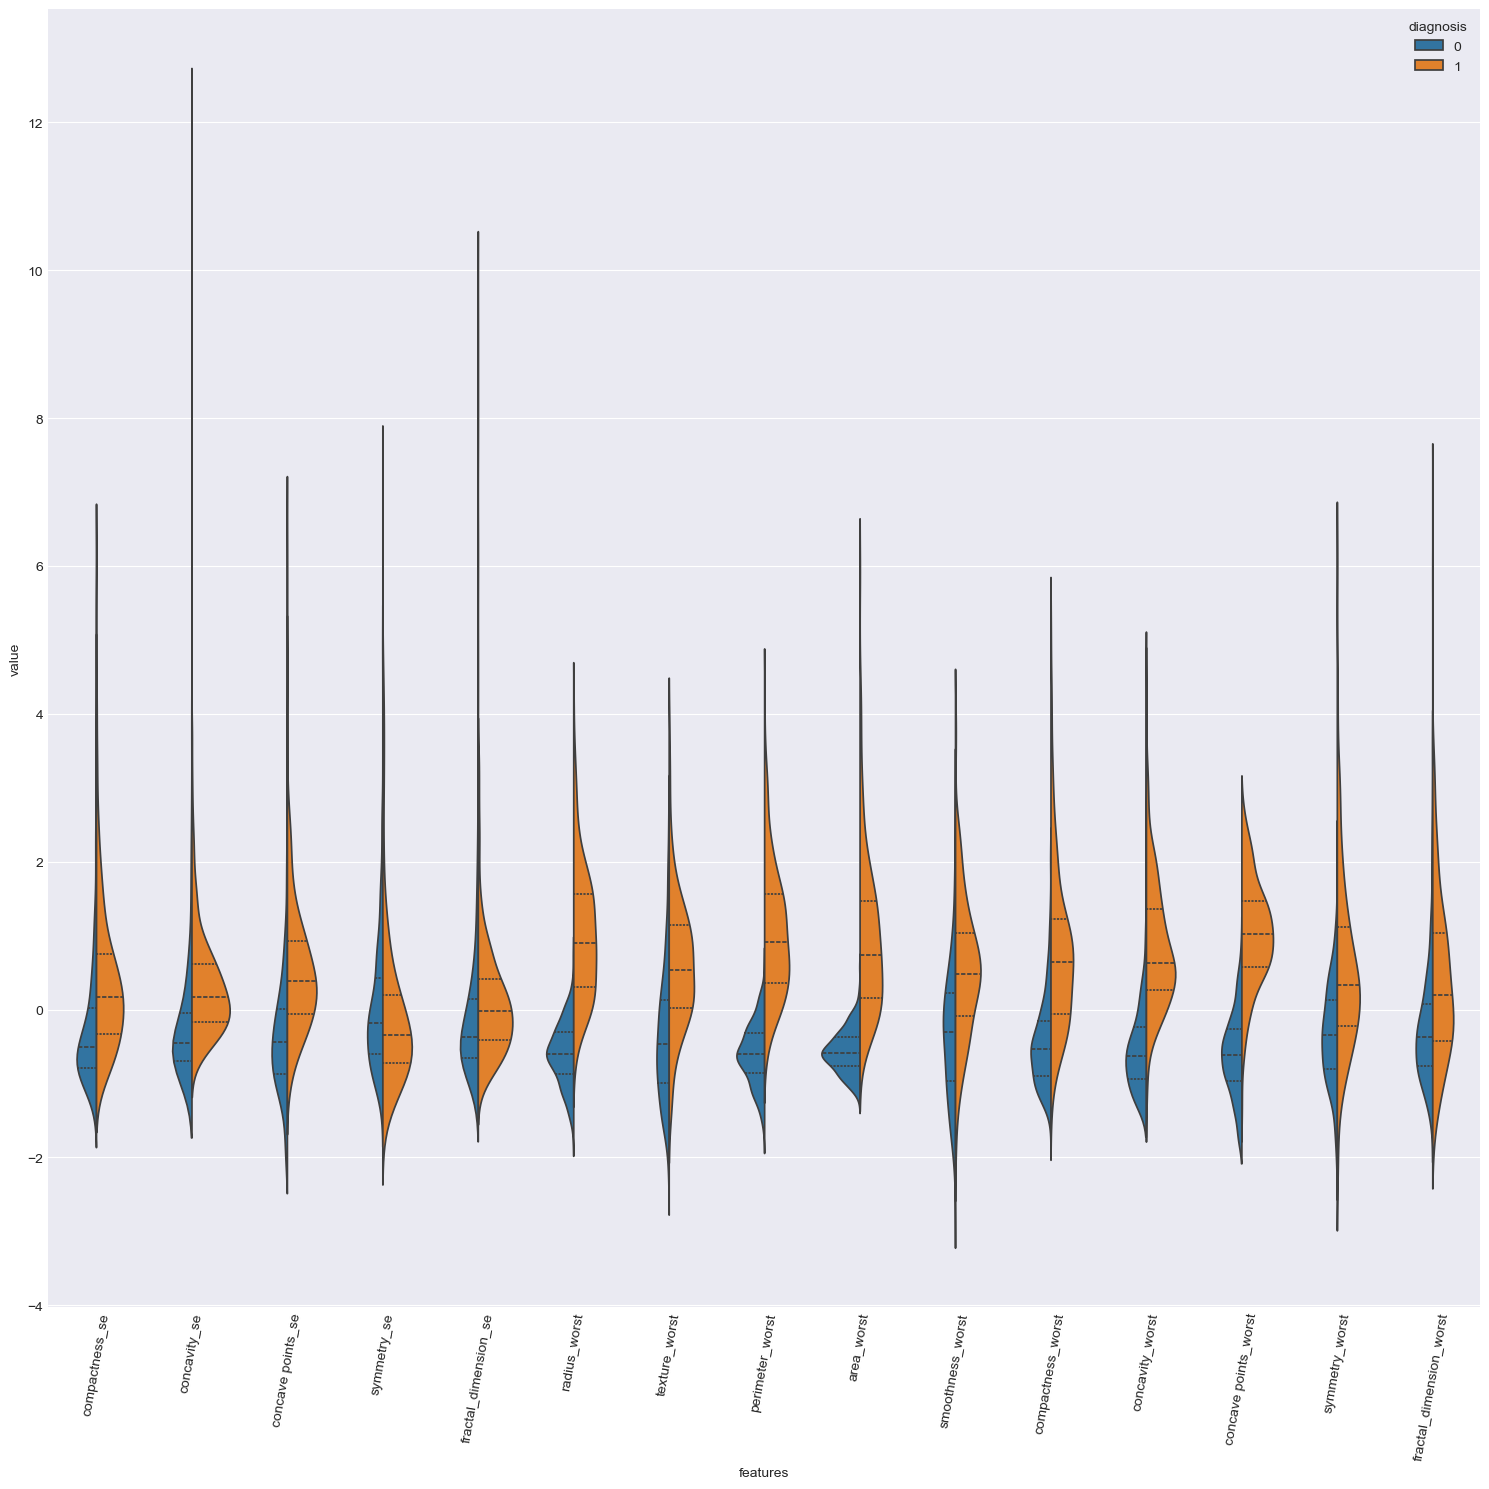

In [12]:
# Últimas quinze features
plot_violin_features(X, y, start=15, end=30)

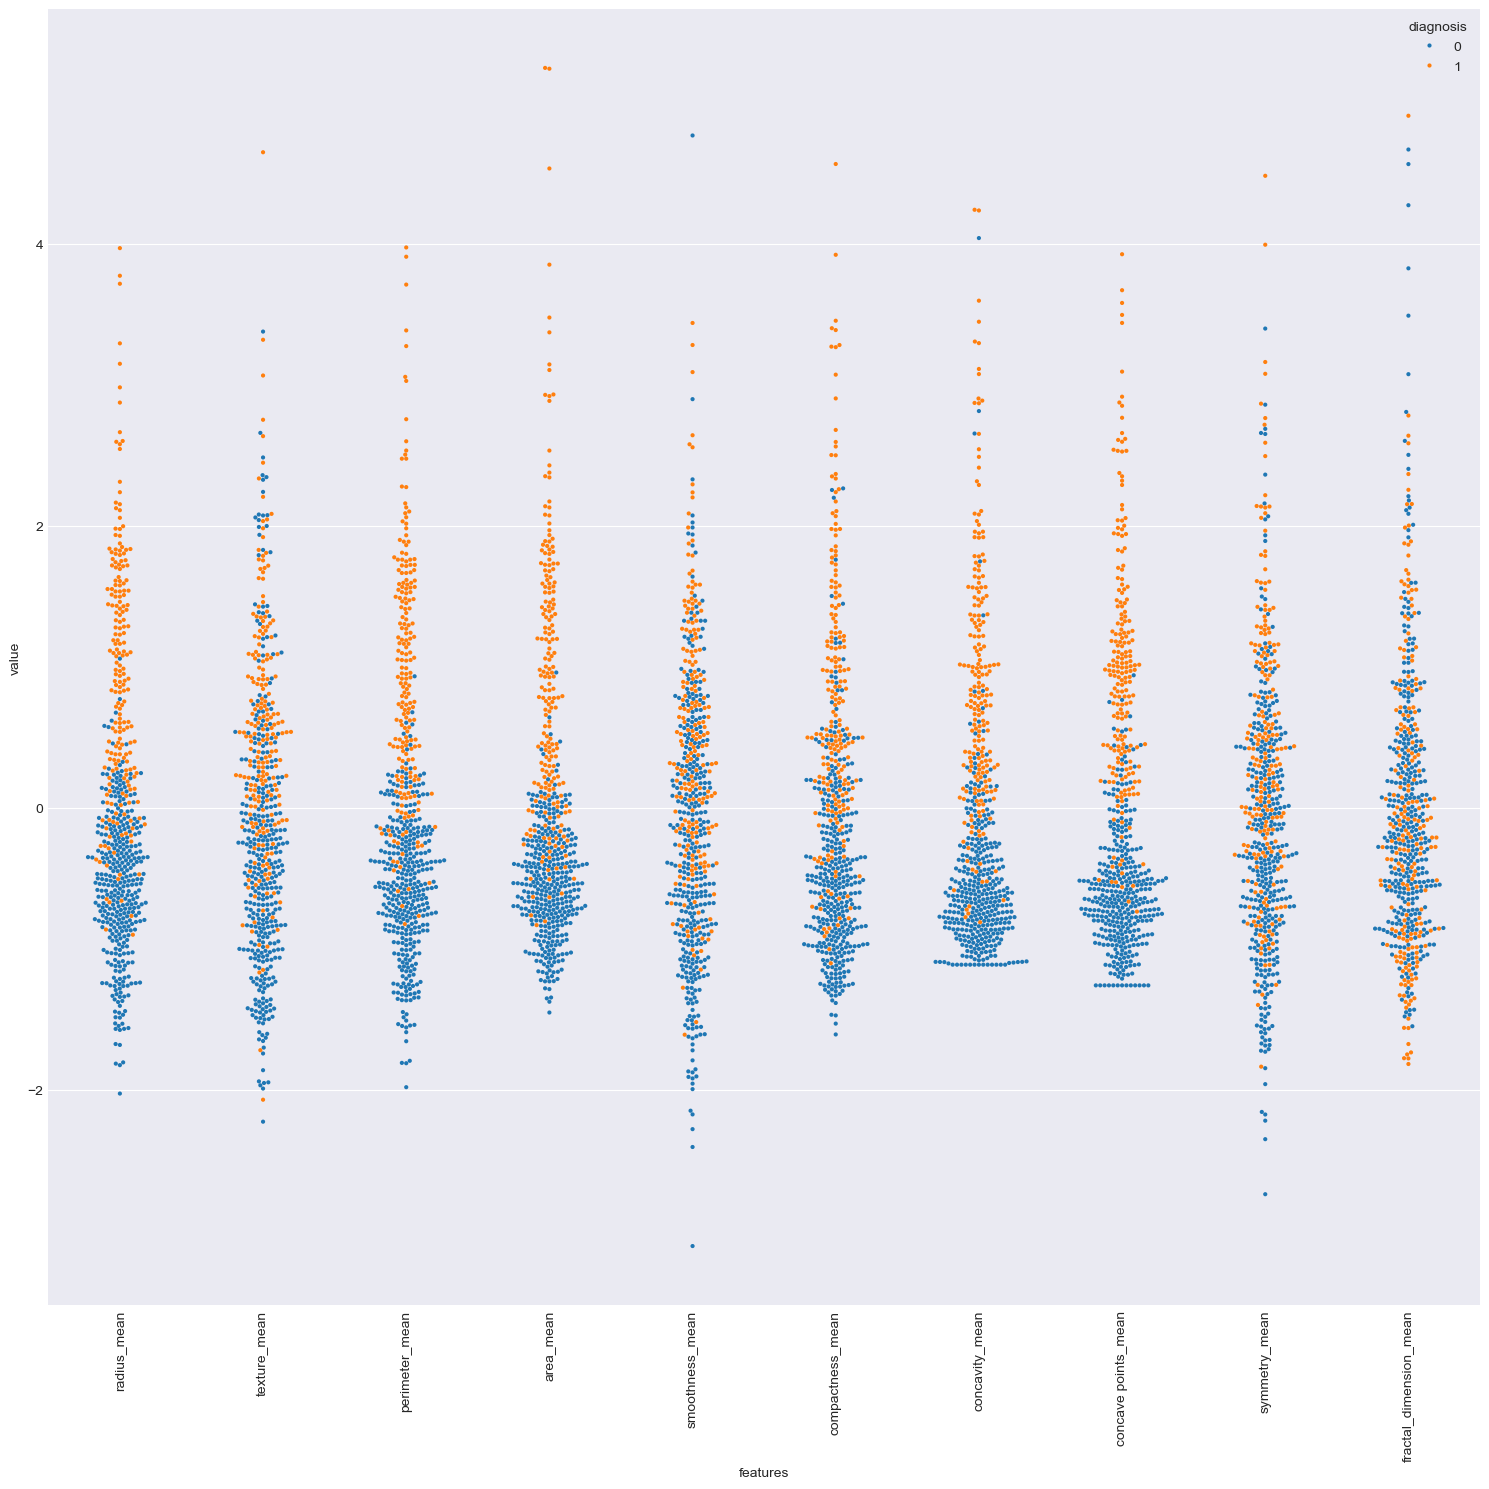

In [13]:
plot_swarm_features(X, y, start=0, end=10, size = 3) # Primeiras 10 features

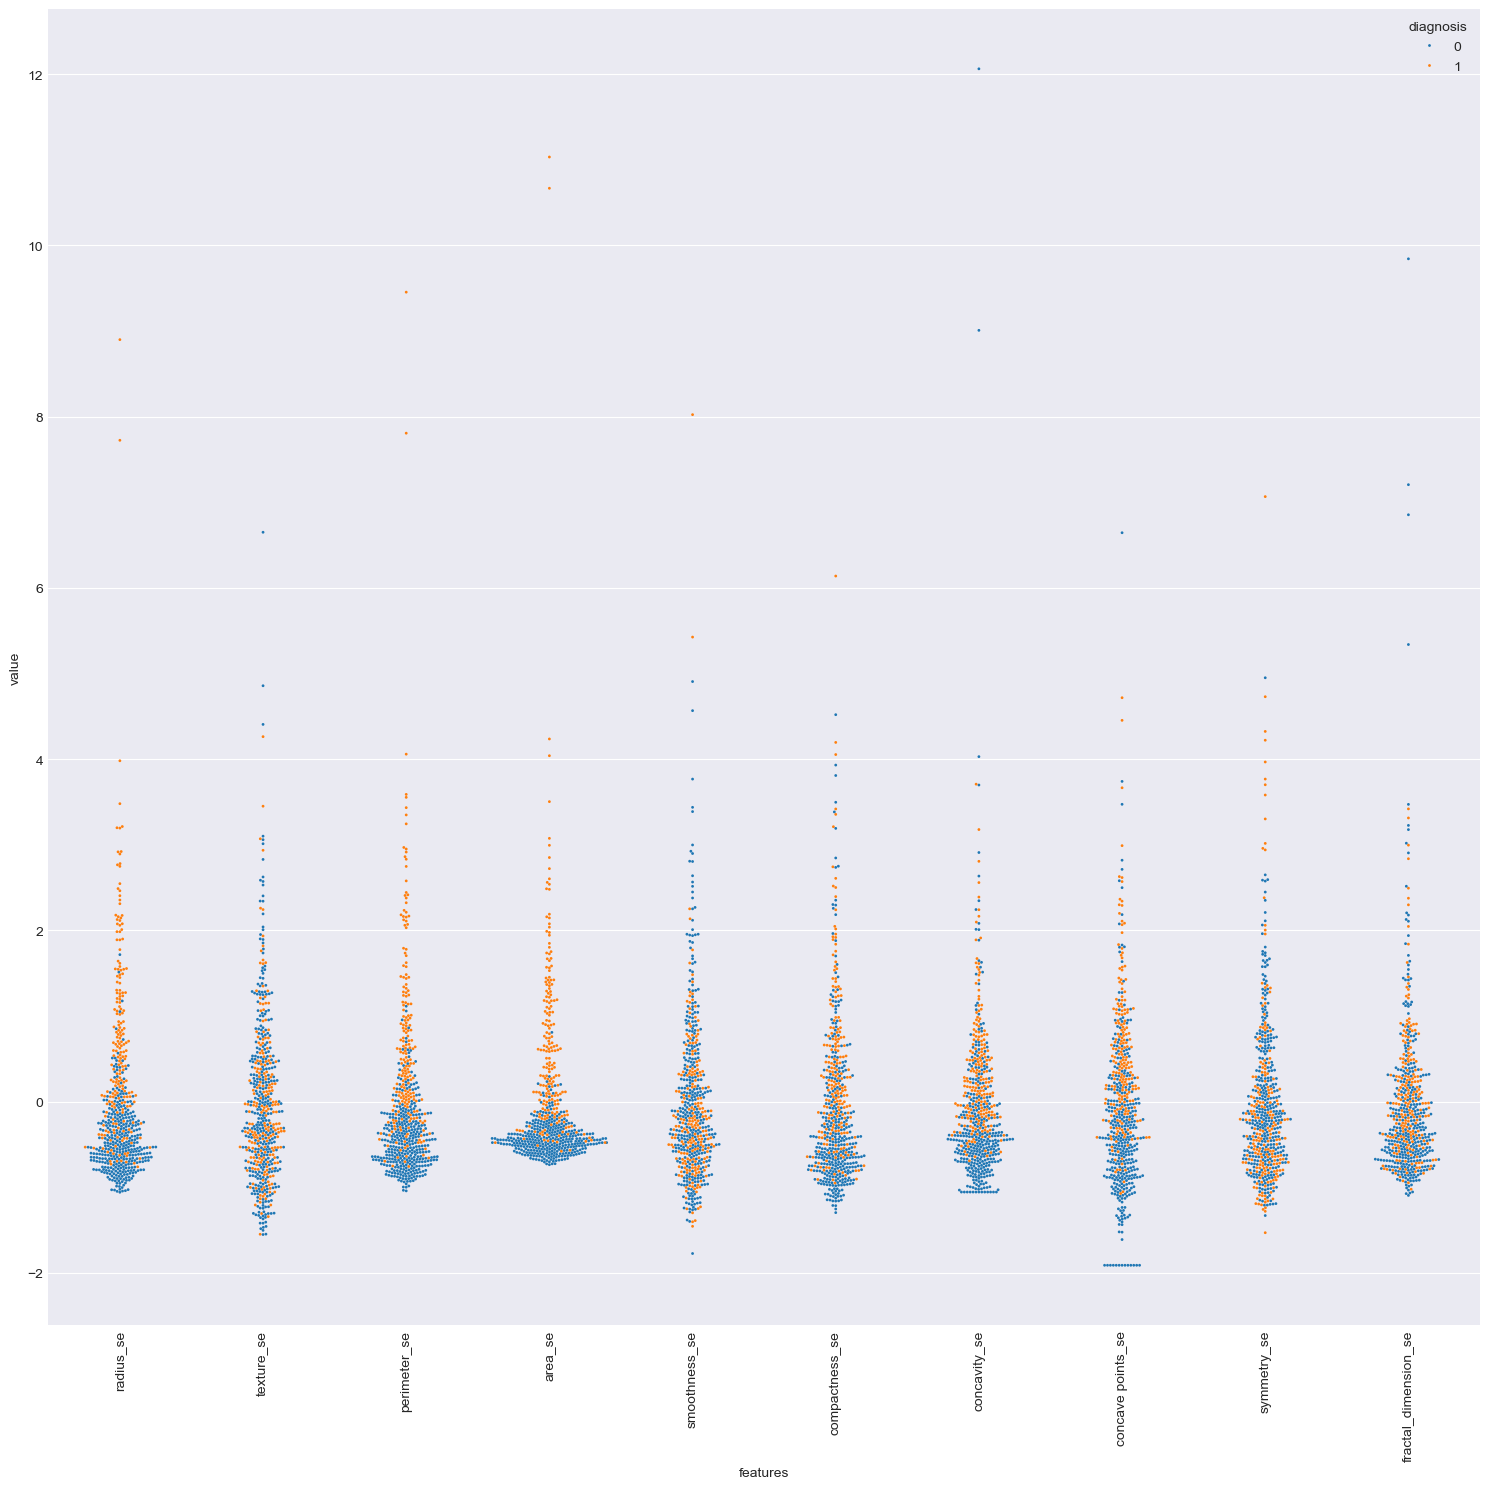

In [14]:
plot_swarm_features(X, y, start=10, end=20, size=2) # Próximas 10 features

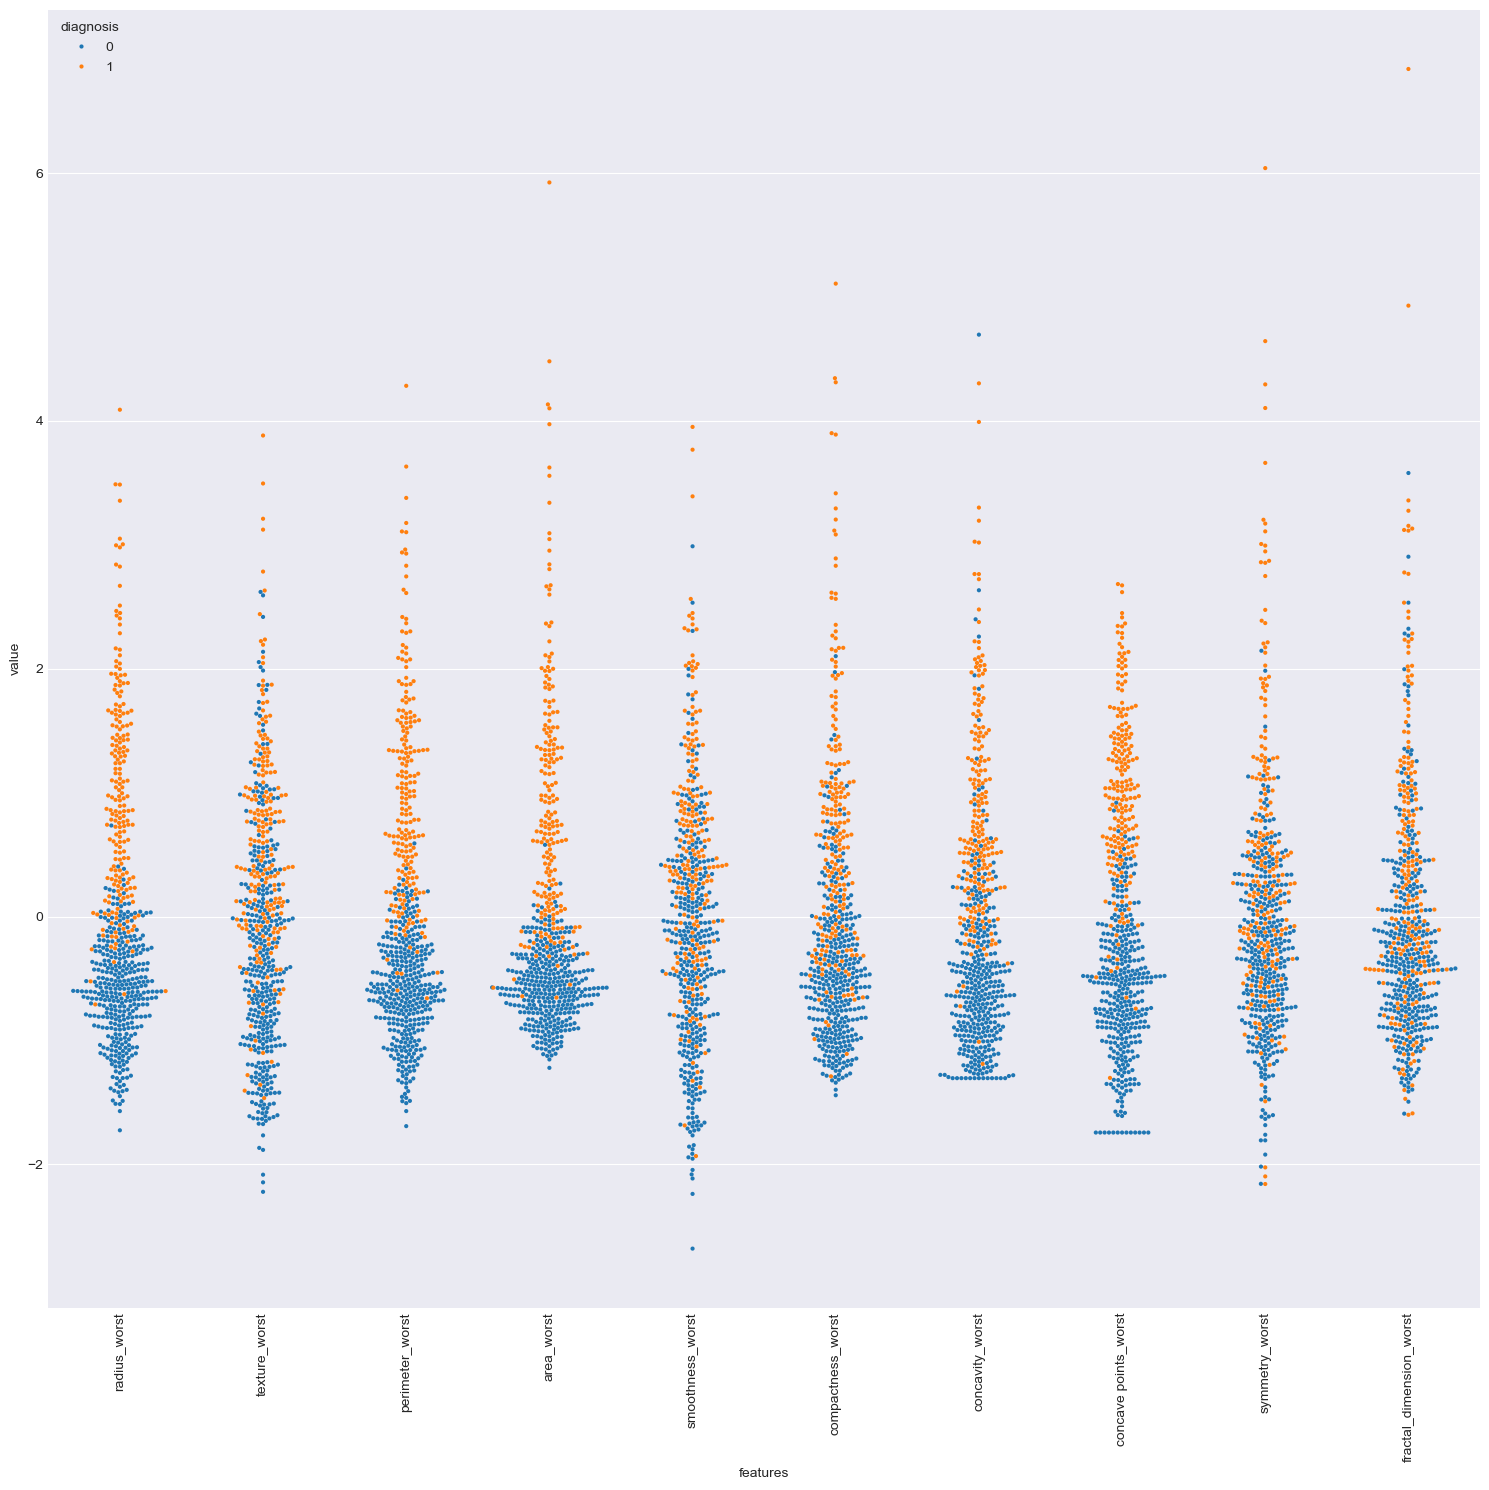

In [15]:
plot_swarm_features(X, y, start=20, end=31, size=3) # Últimas 10 features

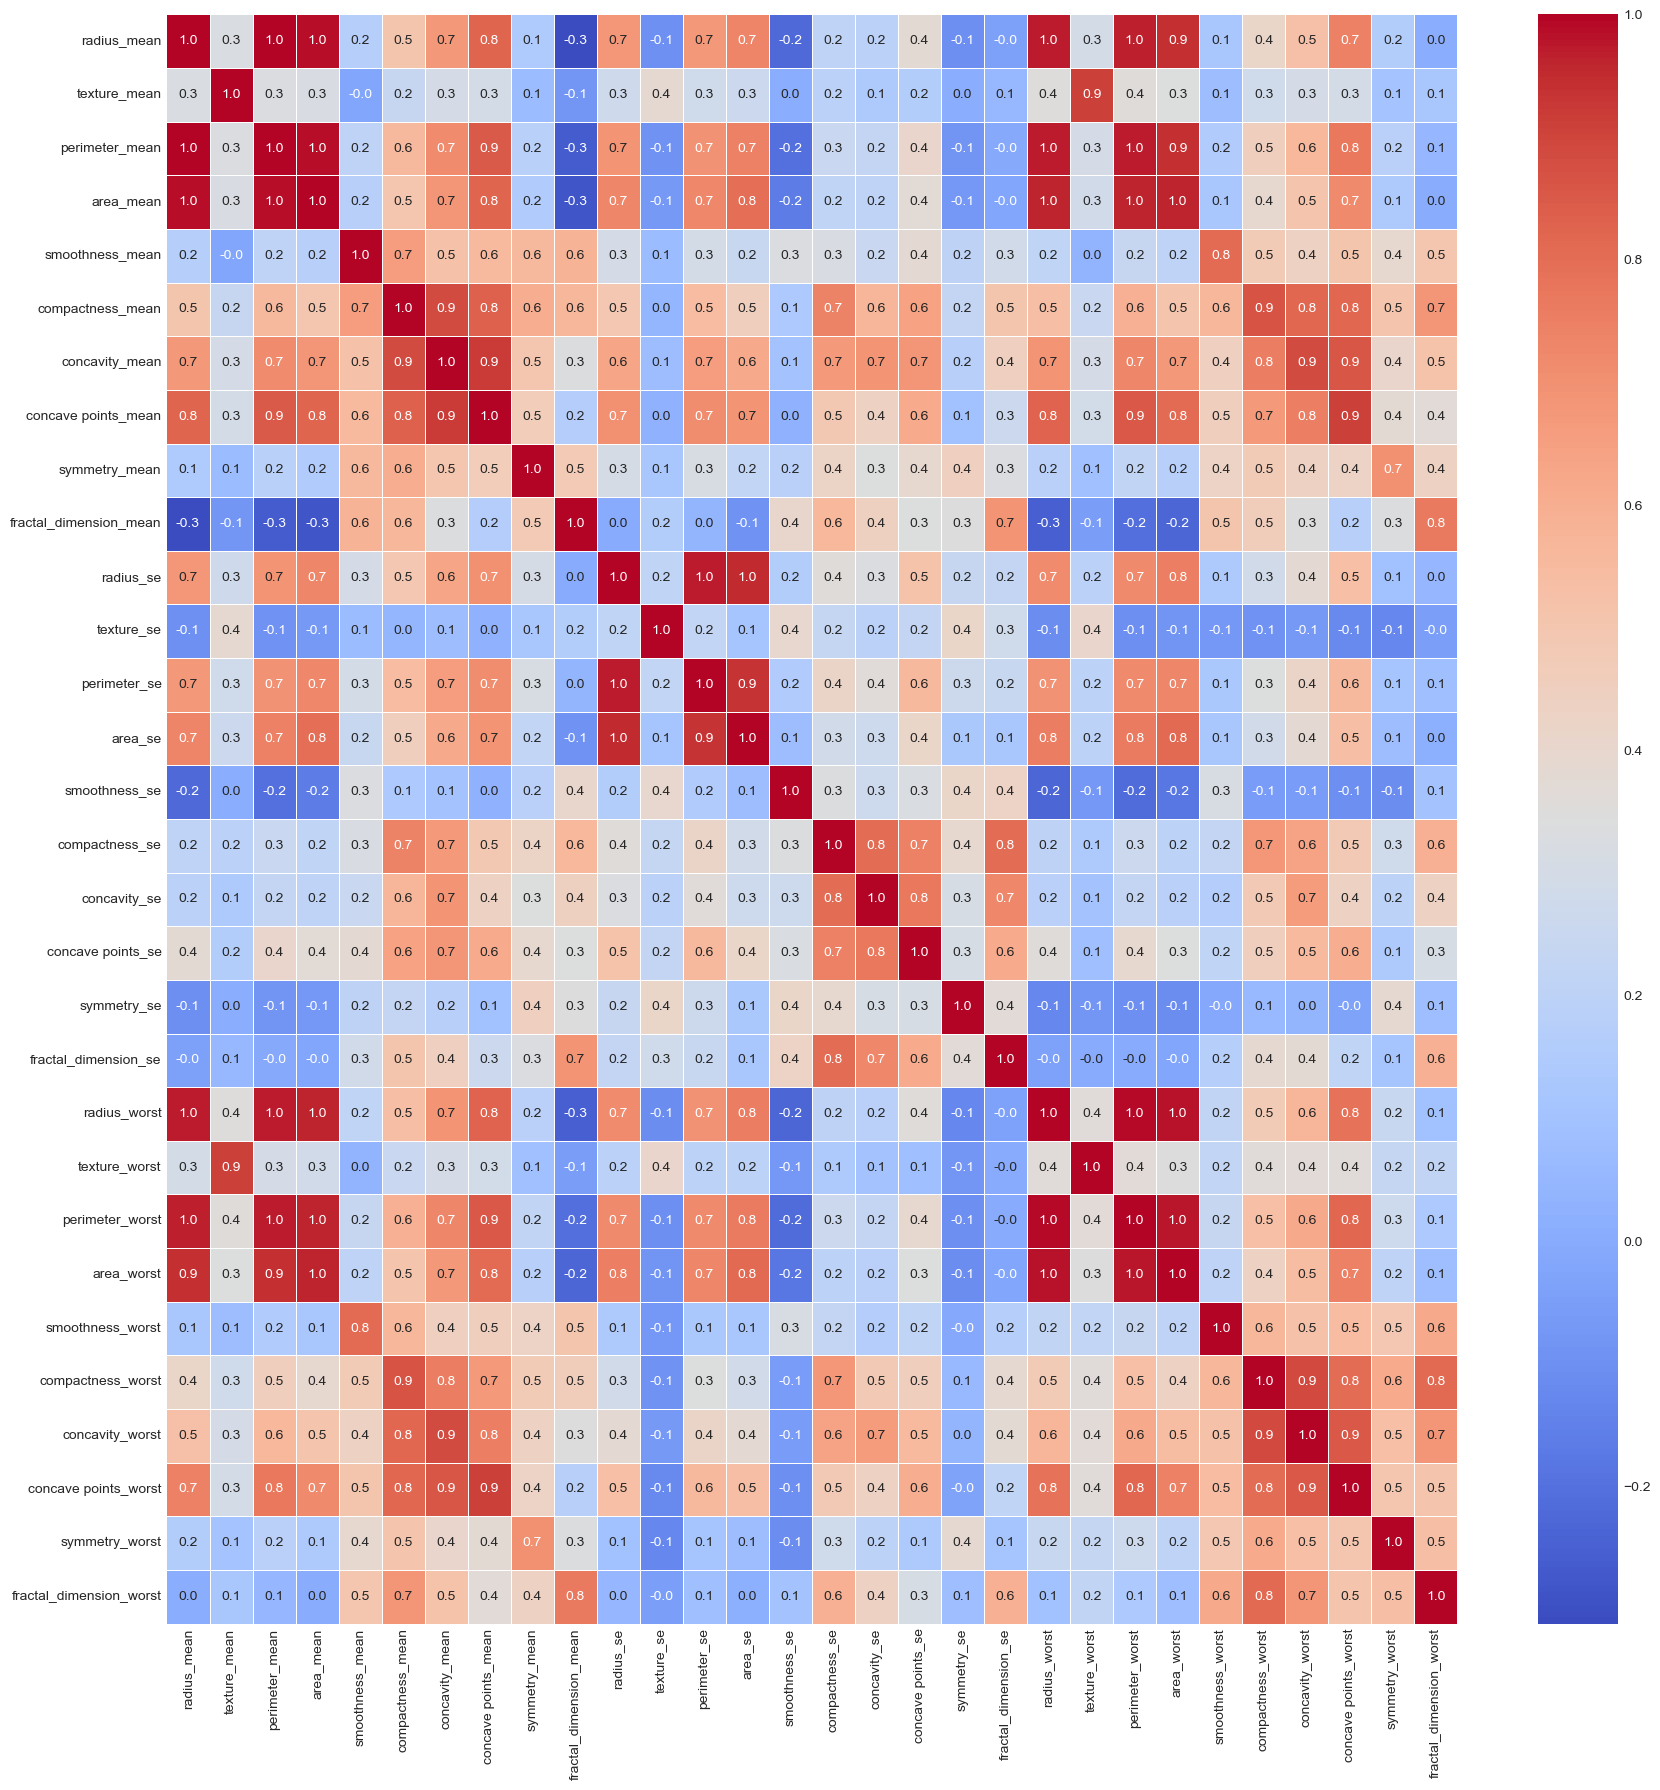

In [16]:
plot_correlation_heatmap(X, figsize=(18, 18))

## Dividindo o dataset em conjunto de treino e teste

In [17]:
X_train, X_test, y_train, y_test = split_data(X, y)

## **Feature selection com correlação**

In [18]:
drop_list = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se',
             'radius_worst','perimeter_worst','compactness_worst', 'concave points_worst','compactness_se', 
             'concave points_se','texture_worst','area_worst', 'fractal_dimension_mean', 'concavity_worst', 'texture_se']

In [19]:
X_train_fs = X_train.drop(columns=drop_list)
X_test_fs = X_test.drop(columns=drop_list)

Observamos agora que não há mais features altamente correlacionadas.

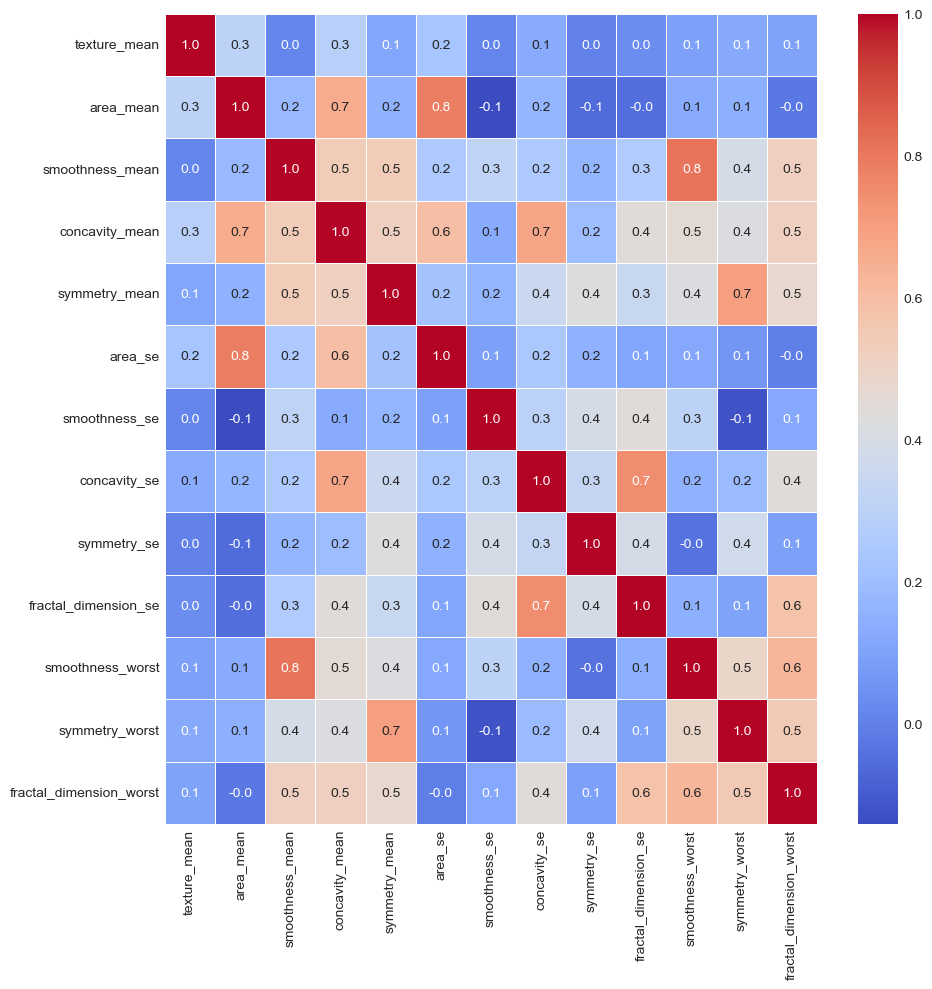

In [20]:
plot_correlation_heatmap(X_train_fs, figsize=(10, 10))

# Treinamento e Avaliação

## **Regressão Logística**


=== Regressão Logística ===
Matriz de Confusão:


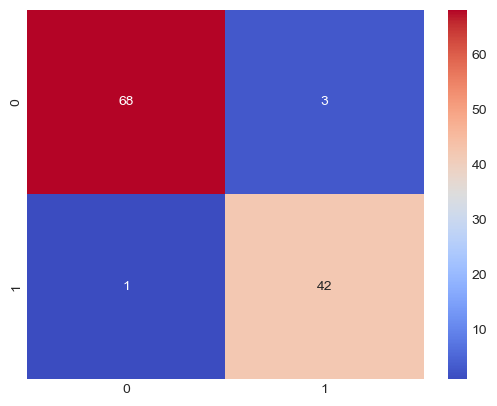

In [21]:
results_lr, model_lr = train_logistic_regression(
    X_train_fs, X_test_fs, y_train, y_test,
    model_name="Regressão Logística"
)

In [22]:
print(results_lr.to_string(index=False))

             Modelo  Accuracy  Recall  Precision  F1 Score    AUC
Regressão Logística    0.9649  0.9767     0.9333    0.9545 0.9951


## Cross Validation

In [23]:
print("Validação Cruzada Regressão Logística:")
print(evaluate_model(
    LogisticRegression(class_weight='balanced'), 
    X_train_fs, 
    y_train
))

Validação Cruzada Regressão Logística:
              precision    recall  f1-score     support
0              0.972318  0.982517  0.977391  286.000000
1              0.969880  0.952663  0.961194  169.000000
accuracy       0.971429  0.971429  0.971429    0.971429
macro avg      0.971099  0.967590  0.969293  455.000000
weighted avg   0.971412  0.971429  0.971375  455.000000


## **Random Forest**


=== Random Forest (FS Corr) ===
Matriz de Confusão:


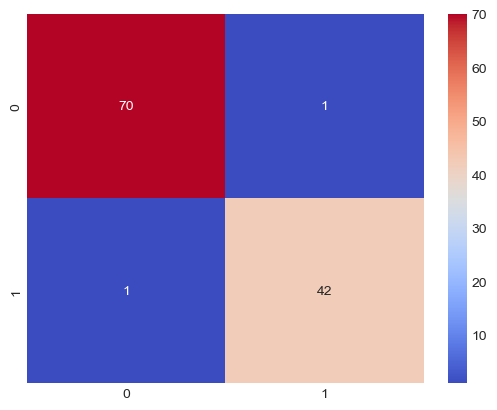

In [24]:
results_rf, model_rf = train_random_forest(
    X_train_fs, X_test_fs, y_train, y_test,
    model_name="Random Forest (FS Corr)"
)

In [25]:
print(results_rf.to_string(index=False))

                 Modelo  Accuracy  Recall  Precision  F1 Score    AUC
Random Forest (FS Corr)    0.9825  0.9767     0.9767    0.9767 0.9985


## Cross Validation

In [26]:
print("Validação Cruzada Random Forest:")
print(evaluate_model(
    RandomForestClassifier(class_weight='balanced'), 
    X_train_fs, 
    y_train,
    scaling=False
))

Validação Cruzada Random Forest:
              precision    recall  f1-score     support
0              0.949495  0.986014  0.967410  286.000000
1              0.974684  0.911243  0.941896  169.000000
accuracy       0.958242  0.958242  0.958242    0.958242
macro avg      0.962089  0.948628  0.954653  455.000000
weighted avg   0.958851  0.958242  0.957933  455.000000


## **Xgboost**


=== XGBoost (Padrão) ===
Matriz de Confusão:


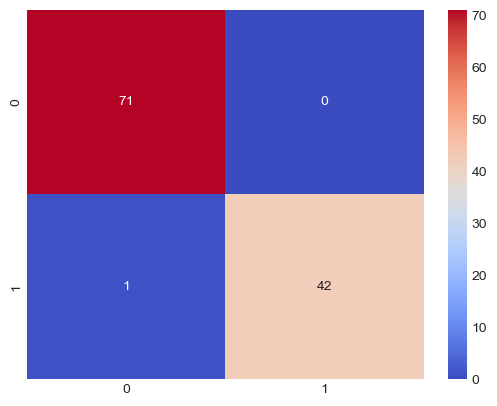

In [27]:
results_xgb, model_xgb = train_xgboost(
    X_train_fs, X_test_fs, y_train, y_test,
    optimize_hyperparams=False
)

In [28]:
results_xgb

,Modelo,Accuracy,Recall,Precision,F1 Score,AUC
0,XGBoost (Padrão),0.9912,0.9767,1.0,0.9882,0.9961


## Cross Validation

In [29]:
print("\nValidação Cruzada - XGBoost (FS):")
print(evaluate_model(
    XGBClassifier(objective='binary:logistic', eval_metric='aucpr'),
    X_train_fs, 
    y_train,
    scaling=False
))


Validação Cruzada - XGBoost (FS):
              precision    recall  f1-score    support
0              0.968531  0.968531  0.968531  286.00000
1              0.946746  0.946746  0.946746  169.00000
accuracy       0.960440  0.960440  0.960440    0.96044
macro avg      0.957639  0.957639  0.957639  455.00000
weighted avg   0.960440  0.960440  0.960440  455.00000


## Encontrando novos parâmetos com Randomized Search

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

=== XGBoost (Hiperparâmetros otimizados) ===
Matriz de Confusão:


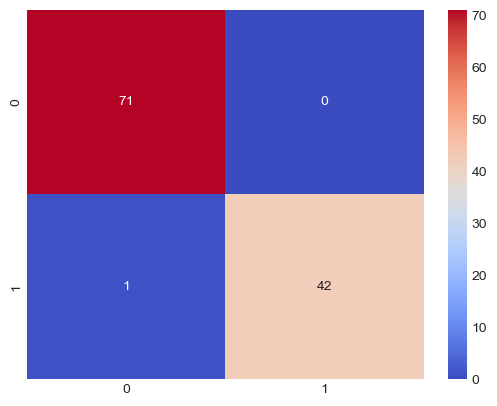

In [30]:
results_xgb_opt, xgb_opt_model, xgb_search = train_xgboost(
   X_train_fs, X_test_fs, y_train, y_test,
    optimize_hyperparams=True
)

In [31]:
results = pd.concat([results_xgb, results_xgb_opt], ignore_index=True)
print(results.to_string(index=False))

                              Modelo  Accuracy  Recall  Precision  F1 Score    AUC
                    XGBoost (Padrão)    0.9912  0.9767        1.0    0.9882 0.9961
XGBoost (Hiperparâmetros otimizados)    0.9912  0.9767        1.0    0.9882 0.9964


## Cross Validation

In [32]:
print("\nValidação Cruzada - XGBoost (Hiperparâmetros otimizados)")
print(evaluate_model(
    xgb_opt_model,
    X_train_fs,
    y_train,
    scaling=False
))


Validação Cruzada - XGBoost (Hiperparâmetros otimizados)
              precision    recall  f1-score     support
0              0.968641  0.972028  0.970332  286.000000
1              0.952381  0.946746  0.949555  169.000000
accuracy       0.962637  0.962637  0.962637    0.962637
macro avg      0.960511  0.959387  0.959943  455.000000
weighted avg   0.962602  0.962637  0.962615  455.000000


## Avaliação ROC/AUC com Cross Validation

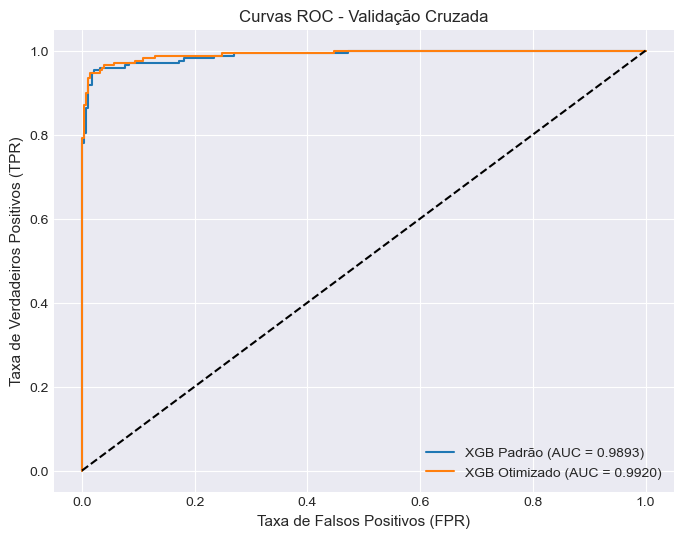

In [33]:
params_base = {
    'objective': 'binary:logistic',
    'random_state': 42,
    'n_estimators': 100,
}

params_opt = xgb_search.best_params_

models = {
    'XGB Padrão': XGBClassifier(**params_base),
    'XGB Otimizado': XGBClassifier(**params_opt)
}

plot_multiple_roc_auc(models, X_train_fs, y_train.values)

## Análise de importância das variáveis com SHAP

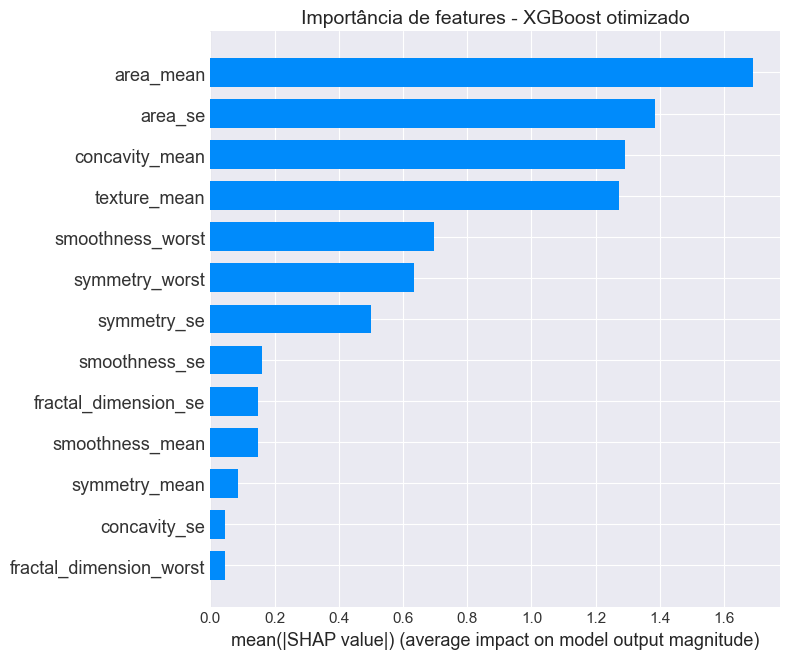

In [34]:
feature_names = X_train_fs.columns.tolist()

xgb_classifier = xgb_opt_model

explainer = shap.TreeExplainer(
    xgb_classifier, 
    feature_names=feature_names
)

shap_values = explainer.shap_values(X_test_fs)

shap.summary_plot(
    shap_values, 
    features=X_test_fs, 
    feature_names=feature_names, 
    plot_type='bar',
    show=False
)

plt.title("Importância de features - XGBoost otimizado", fontsize=14)
plt.tight_layout()
plt.show()

## **SVC**


=== SVC (FS Corr) ===
Matriz de Confusão:


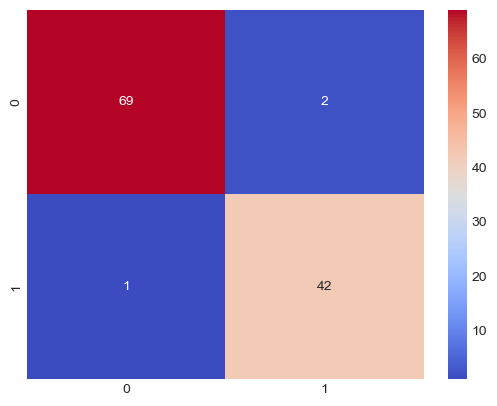

In [35]:
results_svc, model_svc = train_svc(
    X_train_fs, X_test_fs, y_train, y_test,
    model_name="SVC (FS Corr)"
)

In [36]:
print(results_svc.to_string(index=False))

       Modelo  Accuracy  Recall  Precision  F1 Score    AUC
SVC (FS Corr)    0.9737  0.9767     0.9545    0.9655 0.9944


## Cross Validation

In [37]:
print("Relatório de classificação - SVC:")
print("Validação Cruzada SVC:")
print(evaluate_model(
    SVC(class_weight='balanced'), 
    X_train_fs, 
    y_train
))

Relatório de classificação - SVC:
Validação Cruzada SVC:
              precision    recall  f1-score     support
0              0.978873  0.972028  0.975439  286.000000
1              0.953216  0.964497  0.958824  169.000000
accuracy       0.969231  0.969231  0.969231    0.969231
macro avg      0.966045  0.968263  0.967131  455.000000
weighted avg   0.969344  0.969231  0.969267  455.000000


## **KNN**


=== KNN (FS Corr) ===
Matriz de Confusão:


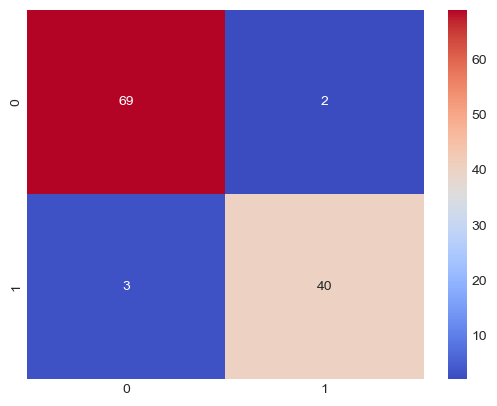

In [38]:
results_knn, model_knn = train_knn(
    X_train_fs, X_test_fs, y_train, y_test,
    model_name="KNN (FS Corr)"
)

In [39]:
print(results_knn.to_string(index=False))

       Modelo  Accuracy  Recall  Precision  F1 Score    AUC
KNN (FS Corr)    0.9561  0.9302     0.9524    0.9412 0.9707


## Cross Validation

In [40]:
print("Relatório de classificação - KNN:")
print("Validação Cruzada KNN:")
print(evaluate_model(
    KNeighborsClassifier(n_neighbors=3), 
    X_train_fs, 
    y_train
))

Relatório de classificação - KNN:
Validação Cruzada KNN:
              precision    recall  f1-score     support
0              0.942761  0.979021  0.960549  286.000000
1              0.962025  0.899408  0.929664  169.000000
accuracy       0.949451  0.949451  0.949451    0.949451
macro avg      0.952393  0.939215  0.945106  455.000000
weighted avg   0.949916  0.949451  0.949077  455.000000


# Seleção de variáveis com Recursive Feature Elimination (RFE) usando XGBoost

In [41]:
X_train, X_test, y_train, y_test = split_data(X, y)

xgb_fs = XGBClassifier(eval_metric='logloss', random_state=1)
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=1)

rfe = RFECV(estimator=xgb_fs, scoring='recall', cv=5, n_jobs=-1)
pipeline = Pipeline([
    ('feature_selection', rfe),
    ('classifier', xgb_clf)
])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(
    pipeline, X_train, y_train, 
    scoring='recall', cv=cv, n_jobs=-1
)
print('Recall (Validação Cruzada): %.3f (± %.3f)' % (np.mean(n_scores), np.std(n_scores)))

Recall (Validação Cruzada): 0.943 (± 0.057)


In [42]:
pipeline.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("\nVariáveis selecionadas:")
print(selected_features.tolist())
print("Número de variáveis:", len(selected_features))


Variáveis selecionadas:
['radius_mean', 'texture_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']
Número de variáveis: 17


In [43]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

## Treinamento e avaliação da regressão logística com variáveis selecionadas (RFE)


=== Regressão Logística (RFE) ===
Matriz de Confusão:


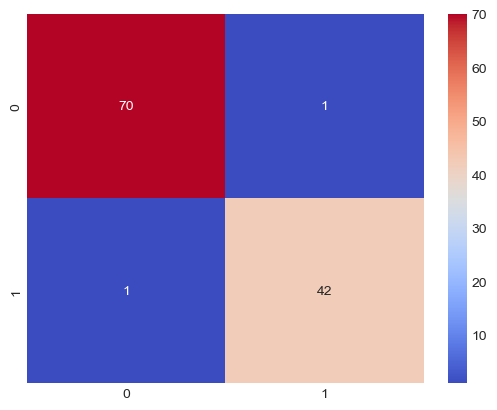

In [44]:
results_lr_RFE, model_lr_RFE = train_logistic_regression(
    X_train_sel, X_test_sel , y_train, y_test,
    model_name="Regressão Logística (RFE)"
)

In [45]:
results = pd.concat([results_lr, results_lr_RFE], ignore_index=True)
print(results.to_string(index=False))

                   Modelo  Accuracy  Recall  Precision  F1 Score    AUC
      Regressão Logística    0.9649  0.9767     0.9333    0.9545 0.9951
Regressão Logística (RFE)    0.9825  0.9767     0.9767    0.9767 0.9980


## Cross Validation

In [46]:
print("Validação Cruzada Regressão Logística:")
print(evaluate_model(
    LogisticRegression(class_weight='balanced'), 
    X_train_sel, 
    y_train
))

Validação Cruzada Regressão Logística:
              precision    recall  f1-score     support
0              0.979094  0.982517  0.980803  286.000000
1              0.970238  0.964497  0.967359  169.000000
accuracy       0.975824  0.975824  0.975824    0.975824
macro avg      0.974666  0.973507  0.974081  455.000000
weighted avg   0.975805  0.975824  0.975809  455.000000


# Feature selection com SelectKBest

## Avaliação do desempenho do modelo para diferentes números de features selecionadas pelo SelectKBest

In [47]:
scores = []
k_values = range(1, X_train.shape[1] + 1)

for k in k_values:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=k)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ])
    
    f1 = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1')
    scores.append(f1.mean())

best_k = k_values[np.argmax(scores)]
best_f1 = max(scores)
print(f"Melhor k: {best_k}, F1-score: {best_f1:.4f}")

Melhor k: 19, F1-score: 0.9764


In [48]:
best_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=best_k)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

best_pipe.fit(X_train, y_train)

selected_mask = best_pipe.named_steps['select'].get_support()
selected_features = X_train.columns[selected_mask]
print(f"Features selecionadas ({len(selected_features)}):", selected_features.tolist())

Features selecionadas (19): ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']


## Plotando a curva F1-score x número de features selecionadas

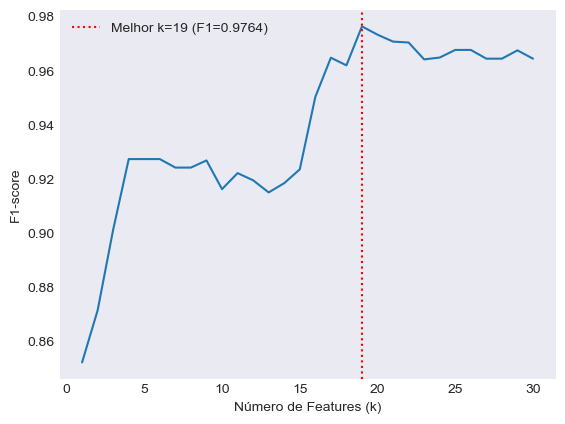

In [49]:
best_k = k_values[np.argmax(scores)]
best_f1 = max(scores)

plt.plot(k_values, scores)
plt.axvline(x=best_k, color='r', linestyle=':', label=f'Melhor k={best_k} (F1={best_f1:.4f})')
plt.xlabel('Número de Features (k)')
plt.ylabel('F1-score')
plt.legend()
plt.grid()
plt.show()

## Seleção final de features usando SelectKBest com k=19

In [50]:
X_train_kbest = best_pipe[:-1].transform(X_train)
X_test_kbest = best_pipe[:-1].transform(X_test)

# Treinamento e avaliação com SelectKBest

## **Regressão Logística**


=== Regressão Logística (SelectKBest) ===
Matriz de Confusão:


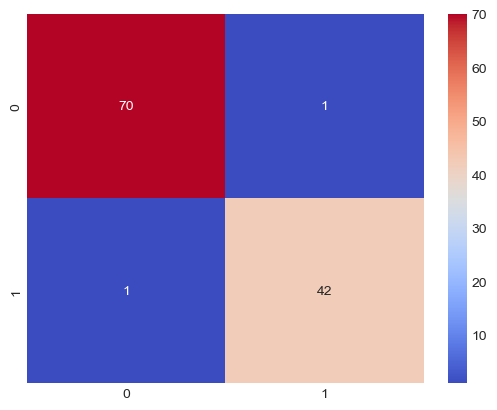

In [51]:
results_lr_KBest, model_lr_KBest = train_logistic_regression(
    X_train_kbest, X_test_kbest , y_train, y_test,
    model_name="Regressão Logística (SelectKBest)",
    scaling=False
)

## Comparando

In [52]:
results = pd.concat([results_lr, results_lr_RFE, results_lr_KBest], ignore_index=True)
print(results.to_string(index=False))

                           Modelo  Accuracy  Recall  Precision  F1 Score    AUC
              Regressão Logística    0.9649  0.9767     0.9333    0.9545 0.9951
        Regressão Logística (RFE)    0.9825  0.9767     0.9767    0.9767 0.9980
Regressão Logística (SelectKBest)    0.9825  0.9767     0.9767    0.9767 0.9967


## Cross Validation

In [53]:
print("Validação Cruzada Regressão Logística (SelectKBest):")
print(evaluate_model(
    LogisticRegression(class_weight='balanced'), 
    X_train_kbest, 
    y_train,
    scaling=False
))

Validação Cruzada Regressão Logística (SelectKBest):
              precision    recall  f1-score     support
0              0.982517  0.982517  0.982517  286.000000
1              0.970414  0.970414  0.970414  169.000000
accuracy       0.978022  0.978022  0.978022    0.978022
macro avg      0.976466  0.976466  0.976466  455.000000
weighted avg   0.978022  0.978022  0.978022  455.000000


## **SVC**


=== SVC (SelectKBest) ===
Matriz de Confusão:


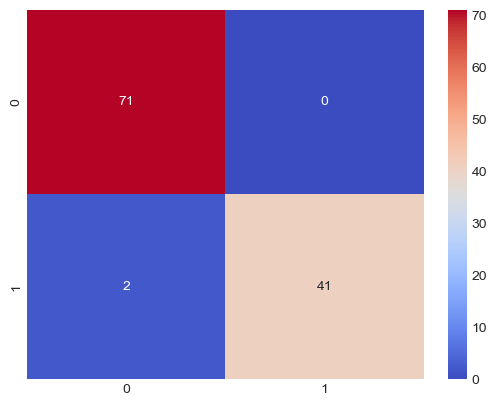

In [54]:
results_svc_kbest, model_svc_kbest = train_svc(
    X_train_kbest, X_test_kbest , y_train, y_test, 
    "SVC (SelectKBest)",
    scaling=False)

In [55]:
results = pd.concat([results_svc, results_svc_kbest], ignore_index=True)
print(results.to_string(index=False))

           Modelo  Accuracy  Recall  Precision  F1 Score    AUC
    SVC (FS Corr)    0.9737  0.9767     0.9545    0.9655 0.9944
SVC (SelectKBest)    0.9825  0.9535     1.0000    0.9762 0.9977


## Cross Validation

In [56]:
print("Relatório de classificação - SVC (SelectKBest):")
print(evaluate_model(model_svc_kbest, X_train_kbest, y_train, scaling=False))

Relatório de classificação - SVC (SelectKBest):
              precision    recall  f1-score     support
0              0.975610  0.979021  0.977312  286.000000
1              0.964286  0.958580  0.961424  169.000000
accuracy       0.971429  0.971429  0.971429    0.971429
macro avg      0.969948  0.968800  0.969368  455.000000
weighted avg   0.971404  0.971429  0.971411  455.000000


## **KNN**


=== KNN (SelectKBest) ===
Matriz de Confusão:


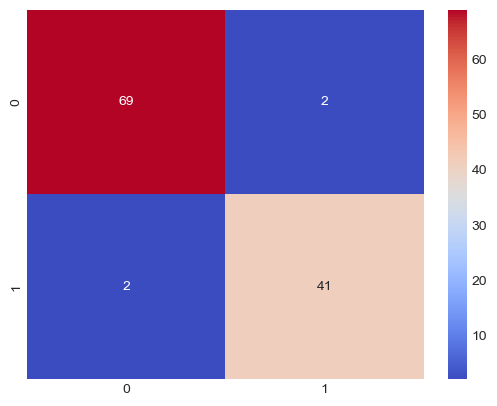

In [57]:
results_knn_kbest, model_knn_kbest = train_knn(
    X_train_kbest, X_test_kbest , y_train, y_test, 
    "KNN (SelectKBest)",
    scaling=False
)

In [58]:
results = pd.concat([results_knn_kbest, results_knn], ignore_index=True)
print(results.to_string(index=False))

           Modelo  Accuracy  Recall  Precision  F1 Score    AUC
KNN (SelectKBest)    0.9649  0.9535     0.9535    0.9535 0.9846
    KNN (FS Corr)    0.9561  0.9302     0.9524    0.9412 0.9707


## Cross Validation

In [59]:
print("Relatório de classificação - KNN (SelectKBest):")
print("Validação Cruzada KNN:")
print(evaluate_model(
    KNeighborsClassifier(n_neighbors=3), 
    X_train_kbest, 
    y_train,
    scaling=False
))

Relatório de classificação - KNN (SelectKBest):
Validação Cruzada KNN:
              precision    recall  f1-score     support
0              0.949324  0.982517  0.965636  286.000000
1              0.968553  0.911243  0.939024  169.000000
accuracy       0.956044  0.956044  0.956044    0.956044
macro avg      0.958939  0.946880  0.952330  455.000000
weighted avg   0.956467  0.956044  0.955752  455.000000


## **Redução de dimensionalidade com PCA**
Dado o alto número de features correlacionadas, utilizei a estratégia de redução de dimensionalidade.

## Separação e padronização dos dados

In [60]:
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train)
X_test_pca_scaled = scaler.transform(X_test)

## Análise da variância explicada

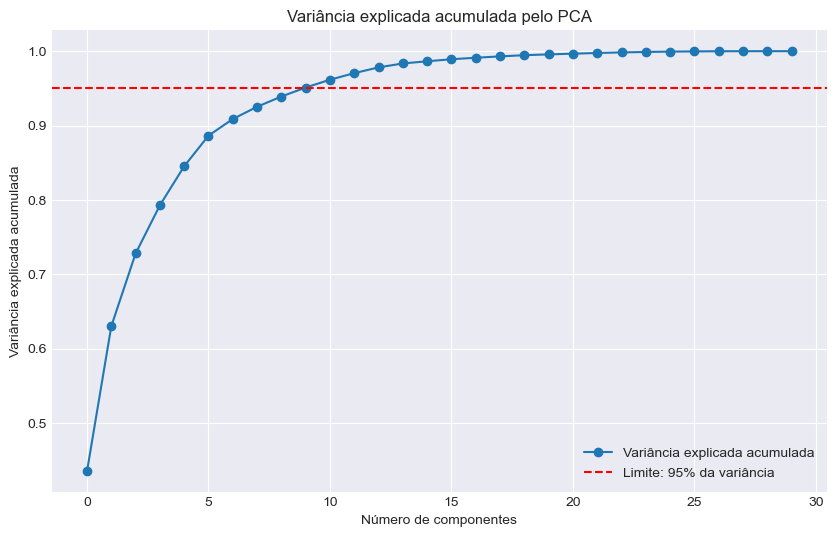

In [61]:
pca = PCA()
pca.fit(X_train_pca_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', label='Variância explicada acumulada')
plt.axhline(y=0.95, color='r', linestyle='--', label='Limite: 95% da variância')
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.title('Variância explicada acumulada pelo PCA')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Aplicação do PCA com número otimizado de componentes

In [62]:
pca = PCA(n_components=0.95)
pca.fit(X_train_pca_scaled)

PCA(n_components=0.95)

In [63]:
X_train_pca = pca.transform(X_train_pca_scaled)
X_test_pca = pca.transform(X_test_pca_scaled)

# Modelagem após PCA

## **Regressão Logística**


=== Regressão Logística (PCA) ===
Matriz de Confusão:


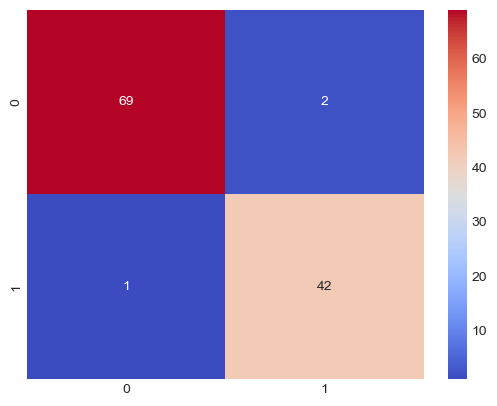

In [64]:
results_lr_pca, model_lr_pca = train_logistic_regression(
    X_train_pca, X_test_pca , y_train, y_test, 
    "Regressão Logística (PCA)",
    scaling=False)

In [65]:
results = pd.concat([results_lr, results_lr_RFE, results_lr_KBest, results_lr_pca], ignore_index=True)
print(results.to_string(index=False))

                           Modelo  Accuracy  Recall  Precision  F1 Score    AUC
              Regressão Logística    0.9649  0.9767     0.9333    0.9545 0.9951
        Regressão Logística (RFE)    0.9825  0.9767     0.9767    0.9767 0.9980
Regressão Logística (SelectKBest)    0.9825  0.9767     0.9767    0.9767 0.9967
        Regressão Logística (PCA)    0.9737  0.9767     0.9545    0.9655 0.9974


## Cross Validation

In [66]:
print("Relatório de classificação - Regressão Logística com PCA:")
print(evaluate_model(model_lr_pca, X_train_pca, y_train, scaling=False))

Relatório de classificação - Regressão Logística com PCA:
              precision    recall  f1-score     support
0              0.975610  0.979021  0.977312  286.000000
1              0.964286  0.958580  0.961424  169.000000
accuracy       0.971429  0.971429  0.971429    0.971429
macro avg      0.969948  0.968800  0.969368  455.000000
weighted avg   0.971404  0.971429  0.971411  455.000000


## **SVC**


=== SVC (PCA) ===
Matriz de Confusão:


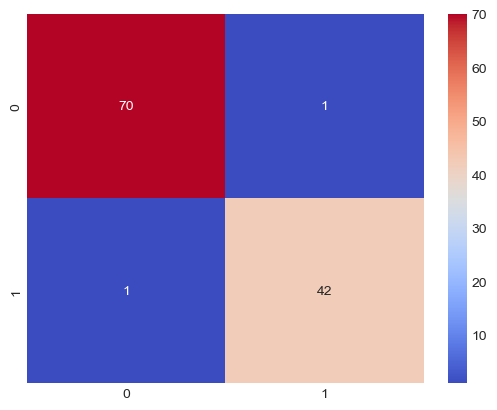

In [67]:
results_svc_pca, model_svc_pca = train_svc(
    X_train_pca, X_test_pca , y_train, y_test, 
    "SVC (PCA)",
    scaling=False    
)

In [68]:
results = pd.concat([results_svc_pca, results_svc_kbest, results_svc], ignore_index=True)
print(results.to_string(index=False))

           Modelo  Accuracy  Recall  Precision  F1 Score    AUC
        SVC (PCA)    0.9825  0.9767     0.9767    0.9767 0.9977
SVC (SelectKBest)    0.9825  0.9535     1.0000    0.9762 0.9977
    SVC (FS Corr)    0.9737  0.9767     0.9545    0.9655 0.9944


## Cross Validation

In [69]:
print("Relatório de classificação - SVC com PCA:")
print(evaluate_model(model_svc_pca, X_train_pca, y_train, scaling=False))

Relatório de classificação - SVC com PCA:
              precision    recall  f1-score     support
0              0.968966  0.982517  0.975694  286.000000
1              0.969697  0.946746  0.958084  169.000000
accuracy       0.969231  0.969231  0.969231    0.969231
macro avg      0.969331  0.964632  0.966889  455.000000
weighted avg   0.969237  0.969231  0.969153  455.000000


## **KNN**


=== KNN (PCA) ===
Matriz de Confusão:


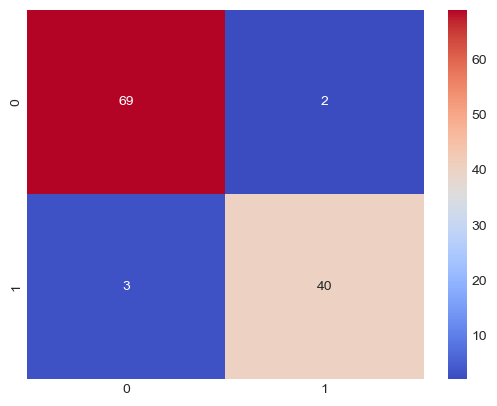

In [70]:
results_knn_pca, model_knn_pca = train_knn(
    X_train_pca, X_test_pca , y_train, y_test, 
    "KNN (PCA)", 
    scaling=False
)

In [71]:
results = pd.concat([results_knn_kbest, results_knn, results_knn_pca], ignore_index=True)
print(results.to_string(index=False))

           Modelo  Accuracy  Recall  Precision  F1 Score    AUC
KNN (SelectKBest)    0.9649  0.9535     0.9535    0.9535 0.9846
    KNN (FS Corr)    0.9561  0.9302     0.9524    0.9412 0.9707
        KNN (PCA)    0.9561  0.9302     0.9524    0.9412 0.9825


## Cross Validation

In [72]:
print("Relatório de classificação - KNN com PCA:")
print(evaluate_model(model_knn_pca, X_train_pca, y_train, scaling=False))

Relatório de classificação - KNN com PCA:
              precision    recall  f1-score     support
0              0.952542  0.982517  0.967298  286.000000
1              0.968750  0.917160  0.942249  169.000000
accuracy       0.958242  0.958242  0.958242    0.958242
macro avg      0.960646  0.949839  0.954774  455.000000
weighted avg   0.958562  0.958242  0.957994  455.000000


## Comparação de modelos

In [73]:
results = pd.concat([
    results_lr, results_rf, results_xgb, 
    results_xgb_opt, results_svc, results_knn,
    results_lr_RFE, results_lr_KBest,
    results_svc_kbest, results_knn_kbest,
    results_lr_pca, results_svc_pca, results_knn_pca
], ignore_index=True)

results.insert(0, 'Técnica', ['FS Corr']*6 + ['RFE']*1 + ['SelectKBest']*3 + ['PCA']*3)
results.index = range(1, len(results)+1)

final_results = (results.style
             .highlight_max(subset=['Accuracy', 'Recall', 'Precision', 'F1 Score'], color='#d4edda')
             .highlight_max(subset=['AUC'], color='#cce5ff')
             .format({
                 'Accuracy': '{:.4f}',
                 'Recall': '{:.4f}',
                 'Precision': '{:.4f}',
                 'F1 Score': '{:.4f}',
                 'AUC': '{:.4f}'
             })
             .set_caption('Comparação de Modelos - Métricas de Performance'))

final_results

,Técnica,Modelo,Accuracy,Recall,Precision,F1 Score,AUC
1,FS Corr,Regressão Logística,0.9649,0.9767,0.9333,0.9545,0.9951
2,FS Corr,Random Forest (FS Corr),0.9825,0.9767,0.9767,0.9767,0.9985
3,FS Corr,XGBoost (Padrão),0.9912,0.9767,1.0000,0.9882,0.9961
4,FS Corr,XGBoost (Hiperparâmetros otimizados),0.9912,0.9767,1.0000,0.9882,0.9964
5,FS Corr,SVC (FS Corr),0.9737,0.9767,0.9545,0.9655,0.9944
6,FS Corr,KNN (FS Corr),0.9561,0.9302,0.9524,0.9412,0.9707
7,RFE,Regressão Logística (RFE),0.9825,0.9767,0.9767,0.9767,0.9980
8,SelectKBest,Regressão Logística (SelectKBest),0.9825,0.9767,0.9767,0.9767,0.9967
9,SelectKBest,SVC (SelectKBest),0.9825,0.9535,1.0000,0.9762,0.9977
10,SelectKBest,KNN (SelectKBest),0.9649,0.9535,0.9535,0.9535,0.9846


## Gráfico de comparação de desempenho dos modelos

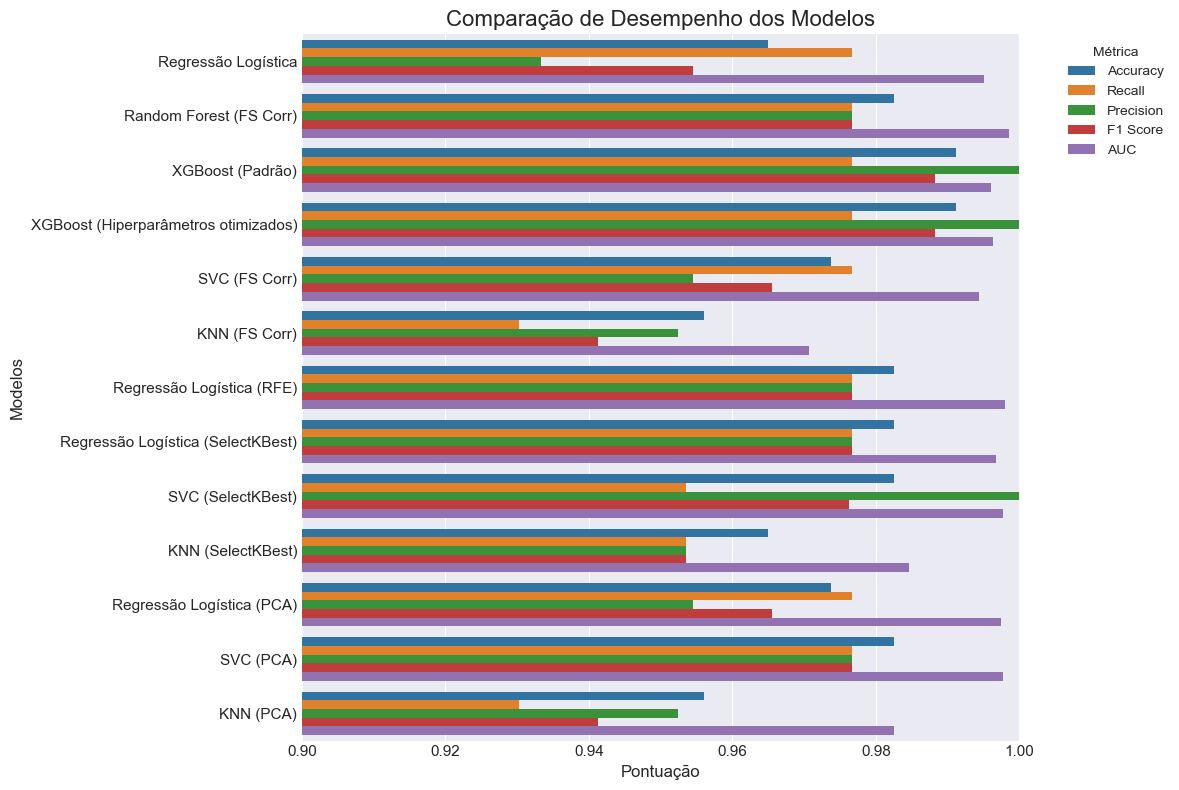

In [74]:
results_long = results.melt(id_vars='Modelo', 
                            value_vars=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC'],
                            var_name='Métrica', 
                            value_name='Valor')

plt.figure(figsize=(12, 8))
sns.barplot(data=results_long, y='Modelo', x='Valor', hue='Métrica')
plt.title('Comparação de Desempenho dos Modelos', fontsize=16)
plt.xlim(0.9, 1.0)
plt.xlabel('Pontuação', fontsize=12)
plt.ylabel('Modelos', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Conclusão final sobre a seleção do modelo
Diante do objetivo central deste projeto — **minimizar falsos negativos** na detecção de câncer de mama —, priorizei a métrica de Recall como fator decisivo. Uma classificação incorreta de um caso maligno (falso negativo) pode ter consequências críticas. Após avaliação rigorosa de múltiplas técnicas e algoritmos, o modelo **XGBoost (Padrão ou com Hiperparâmetros Otimizados)** emergiu como a melhor solução, oferecendo o melhor equilíbrio entre precisão diagnóstica e segurança clínica.


### Destaques do modelo selecionado: XGBoost (hiperparâmetros otimizados)
- **Recall**: 0.9767 – detectou praticamente todos os casos positivos
- **Precisão**: 1.0 – nenhuma previsão positiva foi incorreta
- **F1 Score**: 0.9882 – melhor equilíbrio entre sensibilidade e precisão
- **AUC**: 0.9964 – excelente capacidade de separação entre classes

### Vantagens-chave
- Reduz o risco de diagnósticos fatais (apenas 1 falso negativo em 114 casos)
- Nenhum falso positivo (100% de precisão)
- Excelente equilíbrio entre métricas
- Forte capacidade discriminativa (AUC próximo de 1)
- Consistência entre validação cruzada e conjunto de teste
- Amplo uso e desempenho confiável em tarefas reais de classificação

## Preparação para deploy
Para tornar o projeto reprodutível e aplicável, o modelo final foi encapsulado em um Pipeline com pré-processamento padronizado, treinado novamente no conjunto de treino e salvo em models/xgboost_breast_cancer_fs_optimized.pkl. Esse arquivo é carregado no aplicativo interativo (app.py), permitindo prever novos casos de forma simples e consistente.

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

=== XGBoost (Hiperparâmetros otimizados) ===
Matriz de Confusão:


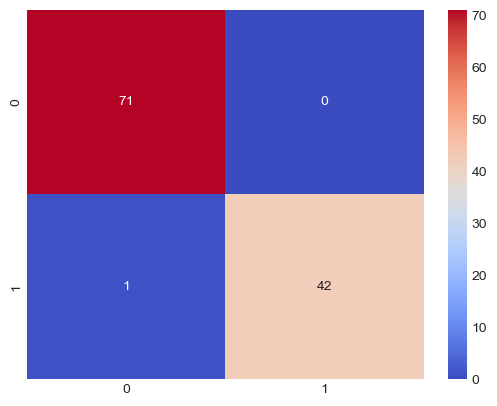

Salvo em models/xgboost_breast_cancer_fs_optimized.pkl


In [75]:
metrics_df, trained_xgb, search = train_xgboost(
    X_train_fs, X_test_fs, y_train, y_test,
    optimize_hyperparams=True,
    n_iter=100,
    cv=10
)

final_pipeline = Pipeline(steps=[
    ('classifier', trained_xgb)
])

final_pipeline.fit(X_train_fs, y_train)

joblib.dump(final_pipeline, "../models/xgboost_breast_cancer_fs_optimized.pkl")
print("Salvo em models/xgboost_breast_cancer_fs_optimized.pkl")

## Créditos e contato

**Desenvolvido por:**  
Bruno Casini

**GitHub:**  
[<img src="https://img.icons8.com/ios-filled/20/000000/github.png"/> GitHub](https://github.com/kzini)  
`https://github.com/kzini`

**LinkedIn:**  
<img src="https://img.icons8.com/ios-filled/20/000000/linkedin.png"/> Em construção 